In [297]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [298]:
#OBJECTIVE: WE WANT TO PREDICT NEXT CHARATCER BY TAKING CONTEXT FROM MORE PREVIOUS CHARACTERS(like 3) INSTEAD OF JUST 1 

In [299]:
#1 read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [300]:
chars = sorted(list(set(''.join(words))))
charIntIndexMapping = {s:i+1 for i,s in enumerate(chars)}
charIntIndexMapping['.'] = 0
indexToCharMapping ={i:s for s,i in charIntIndexMapping.items()}

In [301]:
#2 BUILDING TRAINING DATASET

block_size = 3 # context length: how many characters do we take to predict the next one? basically size of sliding window
inputContext, outputCharcterForThatContext = [], []

for w in words:
  

  contextSlidingWindow = [0] * block_size #Initialise with arr= [0,0,0] where 0 represents '.' char so essentially "..."
    
  for ch in w + '.': #Appending '.' to mark end of word
      
    #NOTE ON APPENDING '.' in Words:
    #1. In bigram model we were appending '.' to start and end of each word 
    #2. Here we dont need to append '.' in starting because we are starting context as "..." 

      
    index = charIntIndexMapping[ch]
    inputContext.append(contextSlidingWindow)
    outputCharcterForThatContext.append(index)
    #print(''.join(indexToCharMapping[i] for i in context), '--->', indexToCharMapping[ix])
    
    contextSlidingWindow = contextSlidingWindow[1:] + [index] #Updating context, so context is like sliding window of size=block_size, when you move to 
    #next iteration you append current char from back in sliding window and first char is removed
    #Syntax context[1:] means taking array from index-1 to last index and appending index represented by current char

#1. inputContext: Represents a matrix where row represents integer form of each possible sliding window of size -3 in all name in names.txt
# and we have 3 columns(bec context_length=3) which represents the content of contextWindow represented by row


#Forexample for emma actually becomes emma.
#Row  Columns(int mapping of char)  contextWindow  
#0->  0,0,0                         ...
#1->  0,0,5                         ..e
#2->  0,5,13                        .em
#3->  5,13,13                       emm
#4->  13,13,1                       mma
#(No entry for ma.)


#2. a. outputCharcterForThatContext: Represents an array of size equal to number of rows in inputContext and outputCharcterForThatContext[i]
#gives index the next character for the sliding window or the context represented by ith row in inputContext
#b. We can say outputCharcterForThatContext is label for our data so we have labelled dataset for our training
inputContext = torch.tensor(inputContext)
outputCharcterForThatContext = torch.tensor(outputCharcterForThatContext)
print(inputContext.shape)
print(outputCharcterForThatContext.shape)


#3. We can change size of sliding window to 4 or 5 or anything in that case our contextWindow will be ....., ....e, ...em, ..emm, .emma,



torch.Size([228146, 3])
torch.Size([228146])


In [302]:
#3 a.Creating Embedding for Each Character so that it can be comfortably for training ML Model like matrix multiplication
#b. In bigram model we created one hot encoding i.e each character was written as 27-bit 
#c. Here we will map each character to 2 dimensional embedding, so for 27 characters we will get 27x2 matrix

noOfDimensionForCharEmbedding = 2
charEmbeddings = torch.randn((27,noOfDimensionForCharEmbedding),requires_grad=True)

charEmbeddings[5] # this gives 2 dimensional embedding of char at index:5  i.e e
print(charEmbeddings[5])

#e. charEmbeddings[5] THIS EMBEDDING IS EQUIVALENT TO:
embedding = F.one_hot(torch.tensor(5), num_classes=27).float() @ charEmbeddings 
embedding
#So we can see charEmbeddings[5] = embedding 
# 1. We created one hot encoding of e as 000010...0 (i.e 1x27 matrix) and did matrix multiplication with 27x2 matrix(this matrix is like 
  #weights matrix so we can say our charEmbedding is similar 1 layer neural , so this is first layer of neural net
# 2. so we will be using charEmbedding directly instead of this one hot encoding and matrix multiplication


# charEmbeddings will be used as look up table to find embedding of a char

tensor([-0.1894, -0.5646], grad_fn=<SelectBackward0>)


tensor([-0.1894, -0.5646], grad_fn=<SqueezeBackward4>)

In [303]:
#4. Preparing Input data for neural network which will go to layer-1
inputForLayer1 = charEmbeddings[inputContext]
print(inputForLayer1.shape) # 3-d dimensional(p,q,r) where p-> number of context window possible for all names, q-> size of context window
#basically block_size, r-> the dimension in which each char is embedded so in our case we have embedded each char in 2D(Look at block-2)

#Flattening from 3d to 2d
noOfColAfterFlattening = block_size*noOfDimensionForCharEmbedding
inputForLayer1 = inputForLayer1.view(len(inputContext), noOfColAfterFlattening)
print(inputForLayer1.shape)

torch.Size([228146, 3, 2])
torch.Size([228146, 6])


In [304]:
#5. DEFINING TWO LAYERS OF NEURAL NETWORK
g = torch.Generator().manual_seed(2147483647) # for reproducibility
weightLayer1 = torch.randn((noOfColAfterFlattening, 100), generator=g, requires_grad=True) #layer-1 100 neurons each neuron have 6 weights because input have 6 feuture so we have
#6 weights
biasLayer1 = torch.randn(100, generator=g, requires_grad=True) 

weightLayer2 = torch.randn((100, 27), generator=g, requires_grad=True) # layer-2 27 neurons each neurons have 100 weights because input for layer-2 will havve
#100 feature so we have 100 weight (228146,6 X 6,100--> 228146,100 Matrix which is input for layer-2)
biasLayer2 = torch.randn(27, generator=g, requires_grad=True) #layer-2 27 biases
parameters = [charEmbeddings, weightLayer1, biasLayer1, weightLayer2, biasLayer2]


In [305]:
#6. RUNING UNTRAINED NEURAL NET TO FOR FIRST TIME TO GET RESULT(FORWARD PASS)

h = torch.tanh(inputForLayer1@weightLayer1+biasLayer1) #Output from Layer-1, Range of tanh=[-1,1]
#layer-1 100 biases, bias should be equal to number of neurons in layer
# as o/p from neuron = Summation(wi*xi)+b (if you see each cell of output matrix after multiplication is summation(wi*xi)) and then we add
#bias to each cell of o/p matrix

logits = h@weightLayer2+biasLayer2 #Output from Layer-2

counts = logits.exp()
prob = counts/counts.sum(1,keepdims=True) #prob[i][j] = count[i][j]/(sum of elements in count[i] row)
loss = -prob[torch.arange(len(inputContext)),outputCharcterForThatContext].log().mean()
loss
print("manually calculating loss",loss)

#b. ShortCut for calculation loss using CROSS ENTROPY:
loss = F.cross_entropy(logits,outputCharcterForThatContext)
print("calculating loss through cross entropy",loss)

#We should always use cross entropy function because of following reasons:
    #1. Manual calculation result in creating extra tensors like counts and prob which can be heavy for large dataset
    #2. Pytorch optimises loss calculation using Cross entropy because it clusterup various operation
    #3. VERY IMP REASON:
        #3.1 we do exponentiation of each cell of logits matrix to make counts positive value but if suppose logits[i][j] = 100 or 
        #any slightly big value then e^100 will be cross limits of float datatype and hence count[i][j] = infinity and our prob matrix will go for 
        #toss
        #3.2 How Cross Entropy solves this problems:
        #It finds max value in logits[][] and subtract each element with that value, now since count[][] is normalised hence there will be no impact
        #on count[i][j](bec we are subtracting each element with same value so there will be no impact on normalised value) because of this 
        #optimisation no element can have more than 0 value so no chance of e^x crossing floats limit
    #4. Backprob is easier in this case

manually calculating loss tensor(16.6025, grad_fn=<NegBackward0>)
calculating loss through cross entropy tensor(16.6025, grad_fn=<NllLossBackward0>)


In [306]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
charEmbeddings = torch.randn((27,noOfDimensionForCharEmbedding),generator=g,requires_grad=True)
weightLayer1 = torch.randn((noOfColAfterFlattening, 100), generator=g, requires_grad=True)
biasLayer1 = torch.randn(100, generator=g, requires_grad=True)
weightLayer2 = torch.randn((100, 27), generator=g, requires_grad=True)
biasLayer2 = torch.randn(27, generator=g, requires_grad=True)
parameters = [charEmbeddings, weightLayer1,biasLayer1,weightLayer2,biasLayer2]

In [307]:
#7. TRAINING THE MODEL( FORWARD PASS AND BACKWARD PASS FOR SOME NUMBER OF TIME)
count=0
for _ in range(1000):
    count = count+1
    inputForLayerOne = charEmbeddings[inputContext]
    inputForLayerOne = inputForLayerOne.view(len(inputContext), noOfColAfterFlattening)
    #forward pass
    h = torch.tanh(inputForLayerOne@weightLayer1+biasLayer1)
    logits = h@weightLayer2+biasLayer2
    loss = F.cross_entropy(logits,outputCharcterForThatContext)
    if(count==1000):
     print(loss.item()) #FINAL LOSS AFTER 1000 STEPS, closer to zero better it is bec this is negative log likelihood
    for p in parameters:
        p.grad = None #We will need to optimise charEmbedding(because it has 2 dimension for 27 chars, weights and biases
    loss.backward()
    for p in parameters:
        p.data += -0.1*p.grad #0.1 is learning rate
 
    

2.5609700679779053


In [328]:
#8. Training model in batches: 2.28 lakh windows runing 1000 learning steps takes time
count =0
for _ in range(1000):
    count = count+1
    #In each step we randomly take 32 sliding windows as our input instead of all the sliding windows 
    noOfWindowsToBeUsedPerLearningStep = 32
    randomSlidingWindowsUsed = torch.randint(0, inputContext.shape[0], (noOfWindowsToBeUsedPerLearningStep,))
    inputForLayer1 = charEmbeddings[inputContext[randomSlidingWindowsUsed]]
    inputForLayer1 = inputForLayer1.view(noOfWindowsToBeUsedPerLearningStep, noOfColAfterFlattening)
    h = torch.tanh(inputForLayer1@weightLayer1+biasLayer1)
    logits = h@weightLayer2+biasLayer2
    loss = F.cross_entropy(logits,outputCharcterForThatContext[randomSlidingWindowsUsed])
    if(count==1000):
     print(loss.item()) #FINAL LOSS AFTER 1000 STEPS, closer to zero better it is bec this is negative log likelihood
    for p in parameters:
        p.grad = None #We will need to optimise charEmbedding(because it has 2 dimension for 27 chars, weights and biases
    loss.backward()
    for p in parameters:
        p.data += -0.1*p.grad #0.1 is learning rate

#POINTS TO NOTE:
#You could wrap this whole for loop in a for loop and to run multiple of these 1000 iterations where in 1 iteration we are having 1000
#learning steps and in each learning step we are randomly picking 32 sliding context window

#This final loss is only for the last sliding window of size 32 and not the whole dataset so this final loss is not comparable with one 
#above code block because that loss is for entire dataset and not just for random 32 windows
    

2.6172900199890137


In [339]:
#9. DECIDING CORRECT LEARNING RATE:

#a. We can run prev code block(block no.8) to get jist about how model reacts to different learning rate and we saw model reacts poorly for 
#greater than 1 learning rate, it basically becomes unstable giving any kind of losses

#b. From our random trying learning rates by runing block-8 we inferred we want to try less than 1 learning rate so we will try 0.001 to 0

learningRateWhichWeWillNotUse = torch.linspace(0.001,0,1000)
    #1. Generates 1000 evenly spaced values between 0.001 and 1, increasing linearly. This means each step between successive learning rates
    #is constant (approximately 0.001)
    #2. Linear spacing does not provide as much resolution or fine granularity at smaller learning rate values (like 0.001, 0.002, etc.)   
    #Often, model performance might differ more significantly when changing between these small values, which means for small learning rate
    #we need even more smaller increment in successive data points (than 0.001 which is being given by linear model)


learningRateExponent = torch.linspace(-3,0,1000)#We will get 1000 evenly spaced datapoints from -3 to 0
learningRatesToTry = 10**learningRateExponent
    #learningRatesToTry belongs to [10^-3, 10^0] but here successive increment steps between two data point is quite smaller for smaller values
    #(like 0.001 etc)which makes it more suiteable because generally neural network are quite sensitive to very small change to learning rate
    #hence this helps us to test neural network on very small changes in learning rate


count =0
learningRateUsed = []
lossForLearningRate = [] #represents loss for learningRateUsed[i]
for i in range(1000):
    count = count+1
    noOfWindowsToBeUsedPerLearningStep = 32
    randomSlidingWindowsUsed = torch.randint(0, inputContext.shape[0], (noOfWindowsToBeUsedPerLearningStep,))
    inputForLayer1 = charEmbeddings[inputContext[randomSlidingWindowsUsed]]
    inputForLayer1 = inputForLayer1.view(noOfWindowsToBeUsedPerLearningStep, noOfColAfterFlattening)
    h = torch.tanh(inputForLayer1@weightLayer1+biasLayer1)
    logits = h@weightLayer2+biasLayer2
    loss = F.cross_entropy(logits,outputCharcterForThatContext[randomSlidingWindowsUsed])
    print(loss.item())
    if(i>0): #Because for iteration loss is for raw neural network
        learningRateUsed.append(learningRatesToTry[i-1])
        lossForLearningRate.append(loss.item())
    for p in parameters:
        p.grad = None 
    loss.backward()
    currLearningRate = learningRatesToTry[i]
    for p in parameters:
        p.data += -currLearningRate*p.grad 


4.226062774658203
4.105199337005615
5.639614582061768
5.712347984313965
5.708223342895508
4.3476176261901855
6.0911712646484375
4.142522811889648
5.233285903930664
6.076552867889404
5.5407609939575195
5.016106605529785
5.146538734436035
4.395455837249756
5.307526588439941
5.017735958099365
5.014001369476318
5.621794700622559
5.274484634399414
4.994755268096924
4.9991865158081055
6.154877662658691
4.977024078369141
5.544947624206543
5.054680347442627
5.386801242828369
5.965959072113037
6.335076808929443
5.29340124130249
6.012887001037598
4.770960807800293
5.679904937744141
4.744325160980225
4.730571269989014
4.172183990478516
5.243923664093018
5.109257698059082
5.307076454162598
5.404690742492676
5.118513107299805
5.39094877243042
5.45427131652832
5.040534973144531
5.4330525398254395
4.807716369628906
4.222759246826172
5.7756171226501465
5.54653263092041
4.830023765563965
5.354428768157959
5.409356594085693
4.358945369720459
4.926196575164795
5.423130035400391
5.559236526489258
5.197432

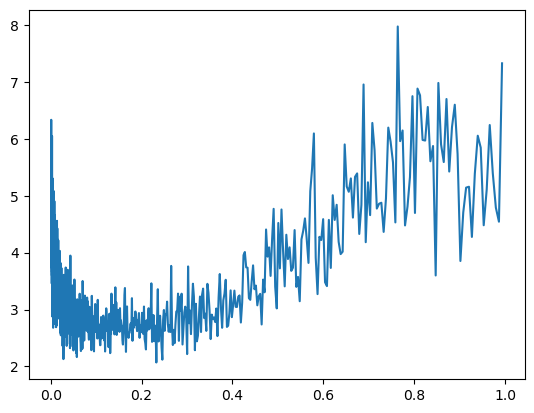

In [340]:
plt.plot(learningRateUsed,lossForLearningRate)
#d. 
    #1. Y-axis loss,  and x-axis is learning rate,we can see a learning is minimum for around 0.1 and beyond 0.2 when we increase learning
    #rate the loss increases quite radically
    
    #2. Seems like 0.1 is good learning rate 

In [346]:
#10. Finalising Learning Rate->Learning Rate Decay

    #1. 0.1 is best learning rate, we will try to run multiple iteration of training(one training we had 1000 learning steps) but once we 
    #get to sense that further training is not further reducing loss then we try training with a learning rate decay
    #2. Learning rate decay is to try to train model with a much smaller learning rate this helps in preventing overfitting. So we will try
    # with 1/10th of ideal learning rate we found, i.e 0.01
    #3. Overfitting: Means when model works well with trained dataset but does not work well new non test data, in a way we can say in those
    #cases model have not learned the patterns rather memorised the results


count =0
for i in range(1000):
    count = count+1
    noOfWindowsToBeUsedPerLearningStep = 32
    randomSlidingWindowsUsed = torch.randint(0, inputContext.shape[0], (noOfWindowsToBeUsedPerLearningStep,))
    inputForLayer1 = charEmbeddings[inputContext[randomSlidingWindowsUsed]]
    inputForLayer1 = inputForLayer1.view(noOfWindowsToBeUsedPerLearningStep, noOfColAfterFlattening)
    h = torch.tanh(inputForLayer1@weightLayer1+biasLayer1)
    logits = h@weightLayer2+biasLayer2
    loss = F.cross_entropy(logits,outputCharcterForThatContext[randomSlidingWindowsUsed])
    for p in parameters:
        p.grad = None 
    loss.backward()
    for p in parameters:
        p.data += -0.01*p.grad 


#Testing the neural network performance for the entire data set
inputForLayerOne = charEmbeddings[inputContext]
inputForLayerOne = inputForLayerOne.view(len(inputContext), noOfColAfterFlattening)
h = torch.tanh(inputForLayerOne@weightLayer1+biasLayer1)
logits = h@weightLayer2+biasLayer2
loss = F.cross_entropy(logits,outputCharcterForThatContext)
print("loss for entire dataset after learning rate decay",loss.item())

#SUMMARY OF DECIDING LEARNING FACTORS
    #1.The process is to try out different learning rate and find suitable learning rate which was 0.1 for our case
    #2. Train the model on this learning rate multiple times, so we have multiple iteration of training where in each iteration we have 1000s
    #learning steps
    #3. After this when we have set our weights and parameter then we do learning rate decay which we did in this block and do training  
    #multiple iterations (here we have done just 1 iteration though)

loss for entire dataset after learning rate decay 2.6752896308898926


In [355]:
#11. SPLITTING DATASET INTO TRAIN/VALIDATION/TEST SPLITS 

#11.1 How Do we split dataset ??

    #1. 80% data to be used for traininig, 10% data for validation and rest 10% percent for testing
    #2. We should conserve the last 10 percent testing portion till the last when we are sure we have built right neural network parameters
    #because after runing test data our model will also learn from it and then our model will perform nice for our dataset but we dont know 
    #how it will perform for random data and our model have kind of memorised rather than learn and this could lead to overfitting model
    #(basically we want dont want to train on testing dataset)

# build the dataset
block_size = 3 

def build_dataset(words):  

    block_size = 3 
    inputContext, outputCharcterForThatContext = [], []
    
    for w in words:
      
    
      contextSlidingWindow = [0] * block_size
        
      for ch in w + '.': 
        index = charIntIndexMapping[ch]
        inputContext.append(contextSlidingWindow)
        outputCharcterForThatContext.append(index)
    #print(''.join(indexToCharMapping[i] for i in context), '--->', indexToCharMapping[ix])
        contextSlidingWindow = contextSlidingWindow[1:] + [index]

    inputContext = torch.tensor(inputContext)
    outputCharcterForThatContext = torch.tensor(outputCharcterForThatContext)
    print(inputContext.shape,outputCharcterForThatContext.shape)
    return inputContext,outputCharcterForThatContext

import random
random.seed(42)
random.shuffle(words)
noOfWordForTraining = int(0.8*len(words))
noOfWordsForValidation = int(0.9*len(words))

inputContextTrain, outputCharacterTrain = build_dataset(words[:noOfWordForTraining])
inputContextValidation, outputCharacterValidation = build_dataset(words[noOfWordForTraining:noOfWordsForValidation])
inputContextTesting, outputCharacterTesting = build_dataset(words[noOfWordsForValidation:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [365]:
#12 Learnig from Training Set and then measuring loss from Validation Set
for i in range(50000):
    noOfWindowsToBeUsedPerLearningStep = 32
    randomSlidingWindowsUsed = torch.randint(0, inputContextTrain.shape[0], (noOfWindowsToBeUsedPerLearningStep,))
    inputForLayer1 = charEmbeddings[inputContextTrain[randomSlidingWindowsUsed]]
    inputForLayer1 = inputForLayer1.view(noOfWindowsToBeUsedPerLearningStep, noOfColAfterFlattening)
    h = torch.tanh(inputForLayer1@weightLayer1+biasLayer1)
    logits = h@weightLayer2+biasLayer2
    loss = F.cross_entropy(logits,outputCharacterTrain[randomSlidingWindowsUsed])
    for p in parameters:
        p.grad = None 
    loss.backward()
    for p in parameters:
        p.data += -0.01*p.grad 

print("loss on training data set",loss.item())


#Testing the neural network performance for the VALIDATION data set
inputForLayerOne = charEmbeddings[inputContextValidation]
inputForLayerOne = inputForLayerOne.view(len(inputContextValidation), noOfColAfterFlattening)
h = torch.tanh(inputForLayerOne@weightLayer1+biasLayer1)
logits = h@weightLayer2+biasLayer2
loss = F.cross_entropy(logits,outputCharacterValidation)
print("loss for entire validation dataset after learning rate decay",loss.item())
#Here our model is not trained on validation dataset, by training on training data again and again we are improving(we did 50k learning 
#steps)

#We can see we have lesser loss on training data set than on validation dataset so we can say to some extend our model is overfitting
#The more closer is loss from training and validation data set the less our model is overfitting

loss on training data set 2.2299423217773438
loss for entire validation dataset after learning rate decay 2.379674196243286


In [383]:
#13. Increasing the size of neural network(i.e increasing number of parameters of neural net)

#1. Our neural net have following params: each character is embedded in to 2 dimenstional vector
#2. Layer-1 have 6 weights and 100 biases 
#3. Layer-2 have 100 weights and 27 biases

#4. Increases neuron in layer-1 from 100 to 300 hence bias also and hence weights in layer-2

noOfDimensionForCharEmbedding = 2
noOfColAfterFlattening = block_size*noOfDimensionForCharEmbedding

g = torch.Generator().manual_seed(2147483647) # for reproducibility
charEmbeddings = torch.randn((27,noOfDimensionForCharEmbedding),generator=g,requires_grad=True)
weightLayer1 = torch.randn((noOfColAfterFlattening, 300), generator=g, requires_grad=True)
biasLayer1 = torch.randn(300, generator=g, requires_grad=True)
weightLayer2 = torch.randn((300, 27), generator=g, requires_grad=True)
biasLayer2 = torch.randn(27, generator=g, requires_grad=True)
parameters = [charEmbeddings, weightLayer1,biasLayer1,weightLayer2,biasLayer2]

sum(p.nelement() for p in parameters) # number of parameters in total

#5. Earlier we had 3k params now we have 10k params 

10281

In [384]:
#14. Training new model with increased params on train dataset

#1. Changing learning rate to 0.1 i.e without decay
lossi = [] #loss for i th step
stepsi = [] # step
for i in range(30000):
    noOfWindowsToBeUsedPerLearningStep = 32
    randomSlidingWindowsUsed = torch.randint(0, inputContextTrain.shape[0], (noOfWindowsToBeUsedPerLearningStep,))
    inputForLayer1 = charEmbeddings[inputContextTrain[randomSlidingWindowsUsed]]
    inputForLayer1 = inputForLayer1.view(noOfWindowsToBeUsedPerLearningStep, noOfColAfterFlattening)
    h = torch.tanh(inputForLayer1@weightLayer1+biasLayer1)
    logits = h@weightLayer2+biasLayer2
    loss = F.cross_entropy(logits,outputCharacterTrain[randomSlidingWindowsUsed])
    for p in parameters:
        p.grad = None 
    loss.backward()
    for p in parameters:
        p.data += -0.1*p.grad  #will start with 0.1 without decay
    lossi.append(loss.item())
    stepsi.append(i)

print("loss on training data set",loss.item())


loss on training data set 2.11135196685791


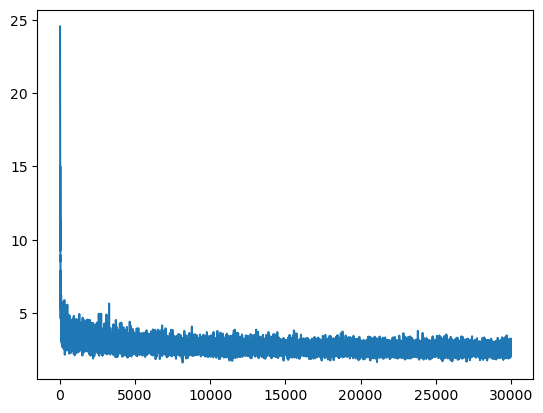

In [385]:
plt.plot(stepsi,lossi) #x-axis-> step and y-axis-> loss
#Even when we are training further loss is not coming down we can see from 5000 learning step beyond loss is not coming, neural net 
#unable to learn any new thing

In [389]:
#15. Testing NEW neural network performance for the VALIDATION data set
inputForLayerOne = charEmbeddings[inputContextValidation]
inputForLayerOne = inputForLayerOne.view(len(inputContextValidation), noOfColAfterFlattening)
h = torch.tanh(inputForLayerOne@weightLayer1+biasLayer1)
logits = h@weightLayer2+biasLayer2
loss = F.cross_entropy(logits,outputCharacterValidation)
print("loss for entire validation dataset",loss.item())

#1. Performance is not that great for traindataset we had 2.1 loss and for validation we have 2.6 loss which is a big difference
#2. Reason:
#a. We have increased number of params 3 times so neural net may take more time to train
#b. Each leaning step we only take 32 window context which might be too small because it might be that we have too much
#noise(means too much distinctive different from each other context) in training that it cant learn anything
#c. We have embedded each character to 2 dimensional vector we can increase the dimensionality as well

loss for entire validation dataset after learning rate decay 2.6565940380096436


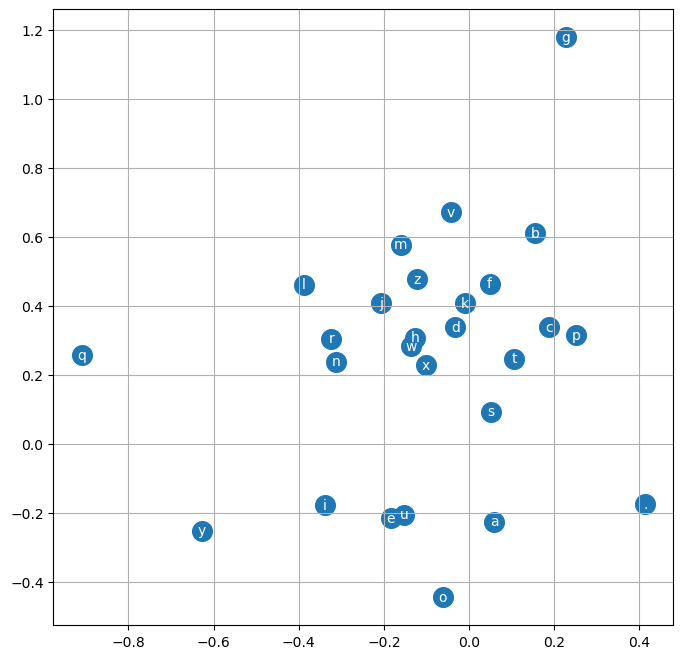

In [395]:
#16. Visualising Chracter Embedding
# visualize dimensions 0 and 1 of the embedding matrix charEmbedding for all characters
plt.figure(figsize=(8,8))
plt.scatter(charEmbeddings[:,0].data, charEmbeddings[:,1].data, s=200)
for i in range(charEmbeddings.shape[0]):
    plt.text(charEmbeddings[i,0].item(), charEmbeddings[i,1].item(), indexToCharMapping[i], ha="center", va="center", color='white')
plt.grid('minor')

#1. Network have learned to cluster character coming together and separate those not coming together, Like vowels are coming
#together, q is quite separate, 
#2. So chars coming closer in this plot shows that neural net thinks this chars are related to each other and might be used interchangebly
#so basically these chars must be adjacent in lots of names in name.txt
#3. Chars which are apart from each other must not be coming together in name in names.txt so q is quite apart, '.' is quite apart from 
#other chars

In [401]:
#17. Increasing dimensionality of character embedding(from 2 to 10 dimensions)

#We will also reduce number of neuron in first layer(i.e hidden layer) to 200 from 300
noOfDimensionForCharEmbedding = 100
numberOfNeuronInLayer1 = 200
learningSteps = 50000
charEmbeddings = torch.randn((27,noOfDimensionForCharEmbedding),requires_grad=True)
noOfColAfterFlattening = block_size*noOfDimensionForCharEmbedding
weightLayer1 = torch.randn((noOfColAfterFlattening, numberOfNeuronInLayer1), generator=g, requires_grad=True)
biasLayer1 = torch.randn(numberOfNeuronInLayer1, generator=g, requires_grad=True)
weightLayer2 = torch.randn((numberOfNeuronInLayer1, 27), generator=g, requires_grad=True)
biasLayer2 = torch.randn(27, generator=g, requires_grad=True)
parameters = [charEmbeddings, weightLayer1,biasLayer1,weightLayer2,biasLayer2]

lossi = [] #loss for i th step
stepsi = [] # step
for i in range(learningSteps):
    noOfWindowsToBeUsedPerLearningStep = 32
    randomSlidingWindowsUsed = torch.randint(0, inputContextTrain.shape[0], (noOfWindowsToBeUsedPerLearningStep,))
    inputForLayer1 = charEmbeddings[inputContextTrain[randomSlidingWindowsUsed]]
    inputForLayer1 = inputForLayer1.view(noOfWindowsToBeUsedPerLearningStep, noOfColAfterFlattening)
    h = torch.tanh(inputForLayer1@weightLayer1+biasLayer1)
    logits = h@weightLayer2+biasLayer2
    loss = F.cross_entropy(logits,outputCharacterTrain[randomSlidingWindowsUsed])
    for p in parameters:
        p.grad = None 
    loss.backward()
    for p in parameters:
        p.data += -0.1*p.grad  #will start with 0.1 without decay
    lossi.append(loss.item())
    stepsi.append(i)
print("loss on training data set",loss.item())

loss on training data set 2.085545539855957


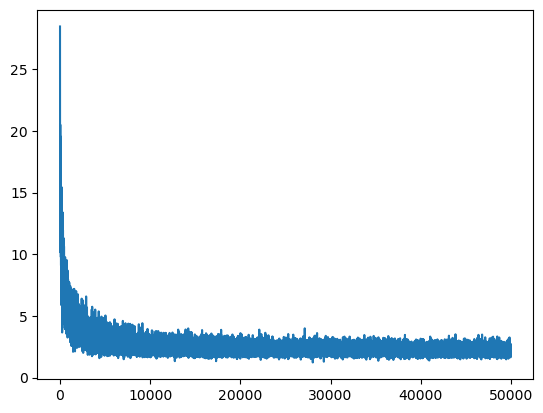

In [402]:
plt.plot(stepsi,lossi) 

In [403]:
#18. Runing neural net on validation set with 100 dimension char embedding and 200 neurons in hidden layer i.e layer-1
inputForLayerOne = charEmbeddings[inputContextValidation]
inputForLayerOne = inputForLayerOne.view(len(inputContextValidation), noOfColAfterFlattening)
h = torch.tanh(inputForLayerOne@weightLayer1+biasLayer1)
logits = h@weightLayer2+biasLayer2
loss = F.cross_entropy(logits,outputCharacterValidation)
print("loss for entire validation dataset",loss.item())

#Loss decreased from 2.65 to 2.32

#2. JOURNEY FROM HERE:
#1. We can play around with learning rate like now try decay of learning rate i.e 0.01
#2. We can train data multiple times on these 50000 training sets
#3. We can increase the size the number of windows being considered from 32 to something bigger
#4. We can increase the block size of the window used from sliding window of 3 to 4 may be
#4. Once we feel that now the difference between loss in training dataset and validation data set has decrease then we can run this neural
#net on test dataset and that can act as out final loss which we can site in our research paper

#PERSON COMMENTED ON YOUTUBE HOW HE GOT MINIMUM LOSS
#This is amazing. Using just a little bit of what I was able to learn from part 3, namely the Kaiming init 
#and turning back on the learning rate decay, I was able to achieve 2.03 and 2.04 in my test and validation with a 1.89 in my training 
#loss with just 300k iterations and 23k parameters. I set my block size to 4 and my embeddings to 12 and increased my hidden layer 
#to 300 while decaying my learning rate exponent from -1 to -3 linear space over the 300k steps. All that without even using batch 
#normalization yet. After applying batch norm, was able to get these down to 1.99 and 1.98 with training loss in the 1.7s 
#after a little more tweaking. Really good content in this lecture, it really has me feeling like a chef in the kitchen almost, 
#cooking up a model with a few turns of the knobs...This sounds like a game or a problem that can be solved with an AI trained 
#on turning knobs.

loss for entire validation dataset 2.3245084285736084


In [ ]:
#19. SAMPLE FROM THE MODEL
